In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/us-accidents/US_Accidents_March23.csv


**Research Question:** *Can we predict crash severity based on environmental (weather) and temporal (time) conditions?*

**Title:** *"Forecasting the Road Ahead: A Data-Driven Model for Predicting High-Risk Driving Conditions"*

# **Upload Dataset**

In [2]:
df=pd.read_csv('/kaggle/input/us-accidents/US_Accidents_March23.csv')

# **Data Preprocessing**

# Fixing data types

In [3]:
df.dtypes

ID                        object
Source                    object
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Street                    object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitation(in)        float64
Weather_Condition         object
Amenity                     bool
Bump      

In [4]:
#Convert all time columns to date/time format
time_columns =['Start_Time', 'End_Time','Weather_Timestamp']
df[time_columns]=df[time_columns].apply(pd.to_datetime,format='mixed')

In [5]:
#seperate time components
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.month
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour

# MISSING VALUES

In [6]:
# 3. Fixing any missing or incorrect values.
(df.isnull().sum() * 100 / len(df)).sort_values(ascending=False)

End_Lat                  44.029355
End_Lng                  44.029355
Precipitation(in)        28.512858
Wind_Chill(F)            25.865904
Wind_Speed(mph)           7.391355
Visibility(mi)            2.291524
Wind_Direction            2.267043
Humidity(%)               2.253301
Weather_Condition         2.244438
Temperature(F)            2.120143
Pressure(in)              1.820288
Weather_Timestamp         1.555666
Nautical_Twilight         0.300787
Civil_Twilight            0.300787
Sunrise_Sunset            0.300787
Astronomical_Twilight     0.300787
Airport_Code              0.292881
Street                    0.140637
Timezone                  0.101030
Zipcode                   0.024779
City                      0.003274
Description               0.000065
Roundabout                0.000000
Stop                      0.000000
Station                   0.000000
Traffic_Signal            0.000000
Traffic_Calming           0.000000
No_Exit                   0.000000
Turning_Loop        

In [7]:
#Missing values are not random as we can see, but we will assume that they are missing at random (MAR) for the purpose of our analysis and imputation.
def fill_precip(row):
    if pd.isna(row['Precipitation(in)']):
        if pd.notna(row['Weather_Condition']) and 'Rain' in row['Weather_Condition']:
            return 0.02  # assumed small rainfall value in inches
        else:
            return 0.0
    else:
        return row['Precipitation(in)']

# Apply the function
df['Precipitation(in)'] = df.apply(fill_precip, axis=1)

In [8]:
#Filling the data with median groups to preserve seasonility(as data is heavily skewed)
df['Wind_Speed(mph)'] = (
    df.groupby(['Station', 'Month', 'Hour'])['Wind_Speed(mph)']
      .transform(lambda x: x.fillna(x.median()))
)


In [9]:
# Check: How many rows have at least one missing value?
rows_with_any_missing = df.isnull().any(axis=1).sum()
pct_with_missing = (rows_with_any_missing / len(df)) * 100

print(f"Rows with ANY missing value: {rows_with_any_missing}")
print(f"Percentage: {pct_with_missing:.2f}%")

Rows with ANY missing value: 3996780
Percentage: 51.72%


In [10]:
df.isnull().any(axis=1)

0           True
1           True
2           True
3           True
4           True
           ...  
7728389    False
7728390    False
7728391    False
7728392    False
7728393    False
Length: 7728394, dtype: bool

In [11]:
# as missing values are too much , we can't drop them so... instead
# firstlt dropping column latitude / longtitude and windchill (as they can inferred or too much missing)
df=df.drop(['End_Lat', 'End_Lng','Wind_Chill(F)'],axis=1)

In [12]:
(len(df) - len(df.dropna()))/len(df)*100

3.9033336033333708

In [13]:
critical_cols = [
    'Severity',
    'Start_Time',
    'Start_Lat', 'Start_Lng',
    'Temperature(F)', 'Humidity(%)',
    'Pressure(in)', 'Visibility(mi)',
    'Wind_Speed(mph)'
]

df[critical_cols].isnull().any(axis=1).sum()/len(df)*100


2.85532802804826

In [14]:
df1=df.copy()


In [15]:

df1=df.dropna()
df1.shape

(7426729, 47)

In [16]:
df.shape

(7728394, 47)

# Handling outliers

The data is heavily imbalanced, and severity 2 completely dominates.
So we group it into balanced class where 

1.Minor (1-2)

2.Moderate(3)

3.Severe(4)

In [17]:
severity_map = {1: 'Minor', 2: 'Minor', 3: 'Moderate', 4: 'Severe'}
df['Severity_Group'] = df['Severity'].map(severity_map)
df['Severity_Group'].value_counts()

Severity_Group
Minor       6224347
Moderate    1299337
Severe       204710
Name: count, dtype: int64

In [18]:
df['Distance(mi)']=df['Distance(mi)']*1.60934
df['Temperature(F)']=(df['Temperature(F)']- 32) * 5/9
df['Visibility(mi)']=df['Visibility(mi)'] *1.60934
df = df.rename(columns={
    'Distance(mi)': 'Distance(km)',
    'Temperature(F)': 'Temperature(C)',
    'Visibility(mi)': 'Visibility(km)'
})
print("done")

done


In [19]:
df.describe()

Severity                     Start_Time  \
count  7.728394e+06                        7728394   
mean   2.212384e+00  2020-06-04 04:23:22.765653248   
min    1.000000e+00            2016-01-14 20:18:33   
25%    2.000000e+00  2018-11-23 04:01:12.249999872   
50%    2.000000e+00            2020-11-11 08:40:22   
75%    2.000000e+00     2022-01-20 07:30:08.500000   
max    4.000000e+00            2023-03-31 23:30:00   
std    4.875313e-01                            NaN   

                            End_Time     Start_Lat     Start_Lng  \
count                        7728394  7.728394e+06  7.728394e+06   
mean   2020-06-04 11:47:48.023094272  3.620119e+01 -9.470255e+01   
min              2016-02-08 06:37:08  2.455480e+01 -1.246238e+02   
25%       2018-11-23 05:45:20.500000  3.339963e+01 -1.172194e+02   
50%              2020-11-11 15:56:29  3.582397e+01 -8.776662e+01   
75%              2022-01-20 17:44:40  4.008496e+01 -8.035368e+01   
max              2023-03-31 23:59:00  4.900220e+01 -6.711317e+01   
std                              NaN  5.076079e+00  1.739176e+01   

       Distance(km)              Weather_Timestamp  Temperature(C)  \
count  7.728394e+06                        7608166    7.564541e+06   
mean   9.041953e-01  2020-06-02 10:06:41.888675840    1.647960e+01   
min    0.000000e+00            2016-01-14 19:51:00   -6.722222e+01   
25%    0.000000e+00            2018-11-20 18:35:00    9.444444e+00   
50%    4.828020e-02            2020-11-10 13:53:00    1.777778e+01   
75%    7.467338e-01            2022-01-19 14:27:00    2.444444e+01   
max    7.109259e+02            2023-03-31 23:53:00    9.722222e+01   
std    2.859492e+00                            NaN    1.056314e+01   

        Humidity(%)  Pressure(in)  Visibility(km)  Wind_Speed(mph)  \
count  7.554250e+06  7.587715e+06    7.551296e+06     7.728394e+06   
mean   6.483104e+01  2.953899e+01    1.462951e+01     7.601382e+00   
min    1.000000e+00  0.000000e+00    0.000000e+00     0.000000e+00   
25%    4.800000e+01  2.937000e+01    1.609340e+01     4.600000e+00   
50%    6.700000e+01  2.986000e+01    1.609340e+01     7.000000e+00   
75%    8.400000e+01  3.003000e+01    1.609340e+01     1.000000e+01   
max    1.000000e+02  5.863000e+01    2.253076e+02     1.087000e+03   
std    2.282097e+01  1.006190e+00    4.326414e+00     5.243852e+00   

       Precipitation(in)          Year         Month           Day  \
count       7.728394e+06  7.728394e+06  7.728394e+06  7.728394e+06   
mean        6.071826e-03  2.019908e+03  6.706355e+00  1.574993e+01   
min         0.000000e+00  2.016000e+03  1.000000e+00  1.000000e+00   
25%         0.000000e+00  2.018000e+03  3.000000e+00  8.000000e+00   
50%         0.000000e+00  2.020000e+03  7.000000e+00  1.600000e+01   
75%         0.000000e+00  2.022000e+03  1.000000e+01  2.300000e+01   
max         3.647000e+01  2.023000e+03  1.200000e+01  3.100000e+01   
std         9.327490e-02  1.914670e+00  3.641262e+00  8.684967e+00   

               Hour  
count  7.728394e+06  
mean   1.232857e+01  
min    0.000000e+00  
25%    8.000000e+00  
50%    1.300000e+01  
75%    1.700000e+01  
max    2.300000e+01  
std    5.464796e+00

This tells us few things about data :-
1. About 75% of the accidents were not very severe (not impacted traffic much)
2. About 75% of accidents impacted 0.077 to 1.2km roughly 
3. Mostly the temperature is between 17 C to 24 celcius
4. Visibility was good in mostly accident (16km )
5. Almost 75% of accident didn't any rain but rain is also very less so we have to look into it(could analyze accidents only on rainy days for targeted impact.)
6. Temperature, Distance , Visibility , Wind speed , Precipitation need to be investigated 

**Temperature**

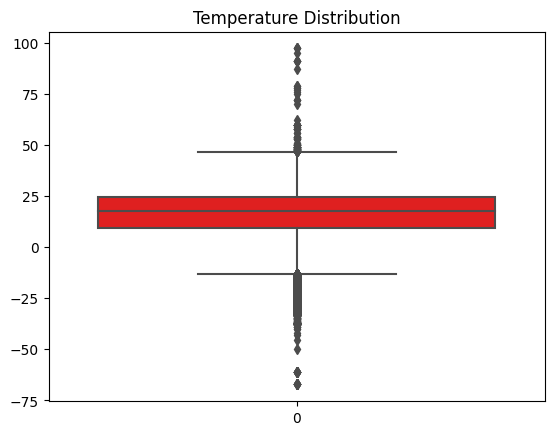

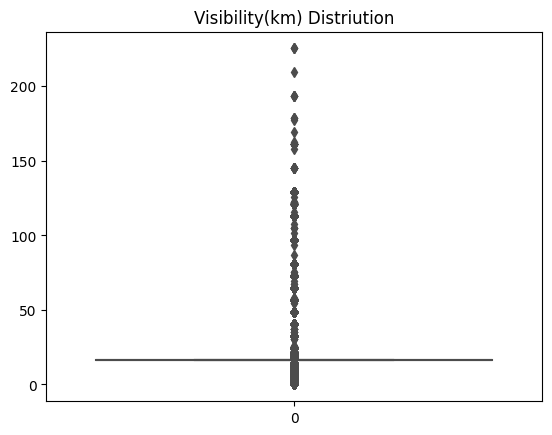

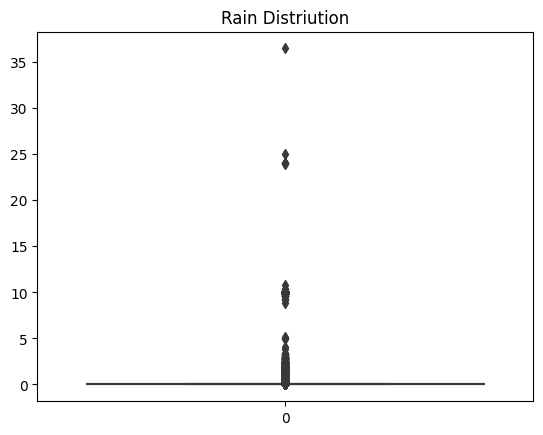

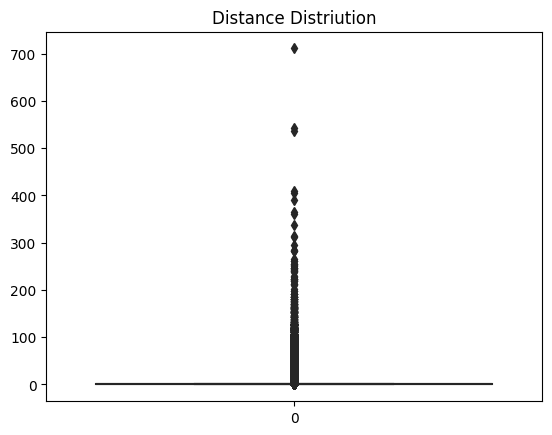

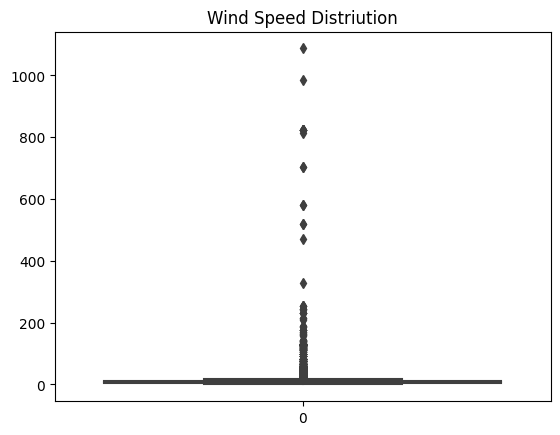

In [20]:
sns.boxplot(df["Temperature(C)"],color='r')
plt.title("Temperature Distribution")
plt.show()
sns.boxplot(df['Visibility(km)'],color='orange')
plt.title('Visibility(km) Distriution')
plt.show()
sns.boxplot(df['Precipitation(in)'].dropna(),color='c')
plt.title('Rain Distriution')
plt.show()
sns.boxplot(df['Distance(km)'],color='g')
plt.title('Distance Distriution')
plt.show()
sns.boxplot(df['Wind_Speed(mph)'])
plt.title('Wind Speed Distriution')
plt.show()

In [21]:
# Get the most extreme temperature cases
extreme_hot = df[df['Temperature(C)'] > 50]  # Hotter than any place on earth
extreme_cold = df[df['Temperature(C)'] < -40]  # Colder than most winters

# Look at them
print(extreme_hot[['Temperature(C)', 'Weather_Condition', 'State', 'Start_Time']].head(10))
print(extreme_cold[['Temperature(C)', 'Weather_Condition', 'State', 'Start_Time']].head(10))

        Temperature(C) Weather_Condition State          Start_Time
177676       55.888889             Clear    IL 2016-07-06 09:16:09
273850       62.000000             Clear    TX 2016-10-21 16:46:19
273856       58.000000             Clear    TX 2016-10-21 17:06:31
273857       58.000000             Clear    TX 2016-10-21 17:06:10
290241       56.000000             Clear    TX 2016-10-11 11:19:42
291717       58.000000          Overcast    TX 2016-10-18 12:02:30
292016       72.000000     Mostly Cloudy    TX 2016-10-19 12:06:30
292035       60.000000     Partly Cloudy    TX 2016-10-19 14:36:25
363906       51.000000             Clear    NE 2017-02-21 09:29:56
504587       75.000000  Scattered Clouds    CT 2017-07-21 11:13:24
         Temperature(C) Weather_Condition State          Start_Time
200806       -61.000000               NaN    NY 2017-01-18 16:40:02
200834       -61.000000               NaN    NY 2017-01-18 18:37:45
201309       -61.000000               NaN    NY 2017-01-23 

In [22]:
extreme_vis=(df[df['Visibility(km)'] > 20])
print(len(extreme_vis)/len(df)*100)

0.3920736960356835


In [23]:
print(df1[df1['Wind_Speed(mph)']>60 ]['Weather_Condition'].head(50))

17802                   Overcast
25414              Mostly Cloudy
25418              Mostly Cloudy
25423              Mostly Cloudy
29297                      Clear
64265                 Light Rain
113098                     Clear
113099                     Clear
113131                     Clear
113147                     Clear
113839                     Clear
114580                     Clear
114588                     Clear
114633                     Clear
114640                     Clear
114647                     Clear
134892          Scattered Clouds
247668                Heavy Rain
247672                Heavy Rain
247674                Heavy Rain
247720                Heavy Rain
288672                     Clear
403987             Mostly Cloudy
464793                     Clear
478379             Mostly Cloudy
489921                  Overcast
491511                     Clear
508146             Partly Cloudy
565576              Fair / Windy
623949      Blowing Dust / Windy
624330    

In [24]:
df[df['Precipitation(in)']>3]['Weather_Condition']

194596        Clear
194765     Overcast
194806     Overcast
195287     Overcast
195328     Overcast
             ...   
7635428    Overcast
7635964       Clear
7635966       Clear
7639274    Overcast
7648088       Clear
Name: Weather_Condition, Length: 519, dtype: object

In [25]:
# Get crashes affecting more than 50km
extreme_distance = df[df['Distance(km)'] > 50]

print(f"Number of crashes with distance > 50km: {len(extreme_distance)}")
print(extreme_distance[['Distance(km)', 'Severity_Group', 'Description', 'State']].head(10))

Number of crashes with distance > 50km: 2594
        Distance(km) Severity_Group  \
40254      82.285554       Moderate   
128572    130.179513          Minor   
129249     52.770259          Minor   
130019     79.002501          Minor   
161529     63.858611          Minor   
165543     87.467629         Severe   
203124     59.658234       Moderate   
203535     59.658234       Moderate   
203565     59.658234       Moderate   
205451     59.658234       Moderate   

                                              Description State  
40254   Accident on I-5 Southbound from I-5 Exit 528 /...    CA  
128572  Accident on FL-91 between Exit 152 FL-70 Okeec...    FL  
129249  Slow traffic and right hand shoulder blocked d...    FL  
130019  Accident on FL-91 Southbound between Exit 242 ...    FL  
161529  Accident on US-20 both ways between Exit 155 C...    IA  
165543  Jackknifed vehicle and heavy snowfall on I-29 ...    IA  
203124  Accident on I-87 NYS Thruway Southbound betwee...    NY

In [26]:
# we'll cap temp at -20 to 50 as almost 98% data lies between them 
df1= df[(df['Temperature(C)'] >= -30) & (df['Temperature(C)'] <= 50)]

<Axes: >

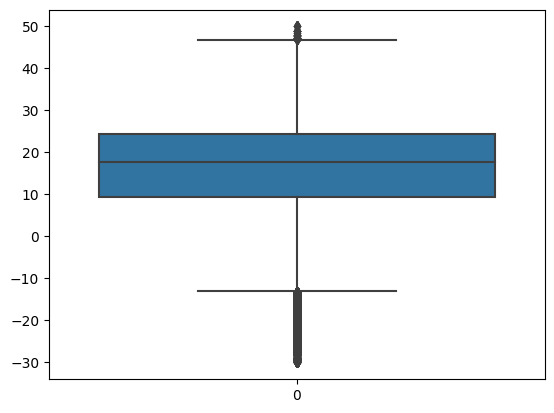

In [27]:
sns.boxplot(df1["Temperature(C)"])

**Variables Removed:**

**Precipitation (28.5% missing)**: Removed due to data quality issues. Analysis revealed 519 cases where precipitation exceeded 3 inches while Weather_Condition indicated "Clear" or "Overcast" weather - a physical impossibility. Since Weather_Condition already captures precipitation information qualitatively (e.g., "Heavy Rain" vs "Light Rain"), the unreliable numerical measurement was deemed redundant.

**Visibility (inconsistent measurements)**: Removed as redundant with Weather_Condition. Visibility measurements represent atmospheric conditions (often from elevated weather stations) rather than driver-level visibility. Weather_Condition categories like "Fog", "Heavy Rain", or "Clear" already capture relevant visibility information for crash analysis.

**Wind_Speed (7% missing)**: Removed due to inconsistencies with Weather_Condition. Analysis showed multiple cases of wind speeds exceeding 60 mph (hurricane-force winds) during conditions labeled "Clear" or "Mostly Cloudy" without wind indicators. Weather_Condition already captures significant wind events through categories like "Fair / Windy" and "Blowing Dust / Windy", making the unreliable numerical measurement redundant.

**Column dropped:-**

1.Start_Lat, Start_Lng: Too granular (13,678 cities, 336,306 streets unmanageable)

2.City, Street: Extreme cardinality, kept State instead (50 categories)

In [28]:
print((df1['Start_Time'].dt.hour - df1['End_Time'].dt.hour).describe())


count    7.564066e+06
mean    -7.115342e-01
std      4.723948e+00
min     -2.300000e+01
25%     -2.000000e+00
50%     -1.000000e+00
75%     -1.000000e+00
max      2.300000e+01
dtype: float64


In [29]:
df1=df1.drop(columns=['Visibility(km)',	'Wind_Speed(mph)','Precipitation(in)',"Start_Lng","Start_Lat","City","Street","Country",'ID', 'Zipcode', 'Timezone', 'Airport_Code', 'End_Time',
        "County",    'Weather_Timestamp', 'Description', 'Wind_Direction'])
df1 = df1[df1['Distance(km)'] <= 5]

In [30]:
df1.shape

(7259928, 31)

In [31]:
df1['Distance(km)'].describe()

count    7.259928e+06
mean     5.016745e-01
std      9.214145e-01
min      0.000000e+00
25%      0.000000e+00
50%      2.253076e-02
75%      5.777531e-01
max      4.998610e+00
Name: Distance(km), dtype: float64

In [32]:
df1.dtypes

Source                           object
Severity                          int64
Start_Time               datetime64[ns]
Distance(km)                    float64
State                            object
Temperature(C)                  float64
Humidity(%)                     float64
Pressure(in)                    float64
Weather_Condition                object
Amenity                            bool
Bump                               bool
Crossing                           bool
Give_Way                           bool
Junction                           bool
No_Exit                            bool
Railway                            bool
Roundabout                         bool
Station                            bool
Stop                               bool
Traffic_Calming                    bool
Traffic_Signal                     bool
Turning_Loop                       bool
Sunrise_Sunset                   object
Civil_Twilight                   object
Nautical_Twilight                object


In [33]:
df.select_dtypes(include=['object']).columns

Index(['ID', 'Source', 'Description', 'Street', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Wind_Direction',
       'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight',
       'Nautical_Twilight', 'Astronomical_Twilight', 'Severity_Group'],
      dtype='object')

In [34]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7259928 entries, 0 to 7728393
Data columns (total 31 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Source                 object        
 1   Severity               int64         
 2   Start_Time             datetime64[ns]
 3   Distance(km)           float64       
 4   State                  object        
 5   Temperature(C)         float64       
 6   Humidity(%)            float64       
 7   Pressure(in)           float64       
 8   Weather_Condition      object        
 9   Amenity                bool          
 10  Bump                   bool          
 11  Crossing               bool          
 12  Give_Way               bool          
 13  Junction               bool          
 14  No_Exit                bool          
 15  Railway                bool          
 16  Roundabout             bool          
 17  Station                bool          
 18  Stop                   bool

**DUPLICATES**

In [35]:
df1['Start_Time'].duplicated().sum()

1706815

In [36]:
duplicates=df1[df1['Start_Time'].duplicated()]
duplicates.head()

Source  Severity          Start_Time  Distance(km) State  \
104  Source2         2 2016-02-11 09:16:13      0.000000    OH   
611  Source2         3 2016-03-11 09:37:00      0.016093    OH   
703  Source2         2 2016-03-17 11:10:37      0.000000    OH   
704  Source2         2 2016-03-17 11:10:37      0.016093    OH   
705  Source2         2 2016-03-17 11:10:37      0.000000    OH   

     Temperature(C)  Humidity(%)  Pressure(in) Weather_Condition  Amenity  \
104      -11.722222         77.0         30.29     Mostly Cloudy    False   
611        8.000000         87.0         30.33          Overcast    False   
703       12.222222         43.0         29.94     Partly Cloudy    False   
704       12.222222         43.0         29.94     Partly Cloudy    False   
705       12.222222         43.0         29.94     Partly Cloudy    False   

     ...  Turning_Loop  Sunrise_Sunset  Civil_Twilight  Nautical_Twilight  \
104  ...         False             Day             Day                Day   
611  ...         False             Day             Day                Day   
703  ...         False             Day             Day                Day   
704  ...         False             Day             Day                Day   
705  ...         False             Day             Day                Day   

     Astronomical_Twilight  Year  Month  Day  Hour  Severity_Group  
104                    Day  2016      2   11     9           Minor  
611                    Day  2016      3   11     9        Moderate  
703                    Day  2016      3   17    11           Minor  
704                    Day  2016      3   17    11           Minor  
705                    Day  2016      3   17    11           Minor  

[5 rows x 31 columns]

In [37]:
# Check if these are TRUE duplicates (same crash reported twice)
# vs. different crashes at same time
duplicate_times = df1[df1['Start_Time'].duplicated(keep=False)]
print(duplicate_times[['Start_Time', 'State', 'Distance(km)', 'Severity']].head(20))

              Start_Time State  Distance(km)  Severity
103  2016-02-11 09:16:13    OH      0.000000         2
104  2016-02-11 09:16:13    OH      0.000000         2
610  2016-03-11 09:37:00    OH      0.016093         2
611  2016-03-11 09:37:00    OH      0.016093         3
702  2016-03-17 11:10:37    OH      0.000000         2
703  2016-03-17 11:10:37    OH      0.000000         2
704  2016-03-17 11:10:37    OH      0.016093         2
705  2016-03-17 11:10:37    OH      0.000000         2
706  2016-03-17 11:10:37    OH      0.016093         2
716  2016-03-18 11:44:25    OH      0.000000         2
717  2016-03-18 11:44:25    OH      0.016093         2
739  2016-06-21 11:06:50    CA      0.000000         2
742  2016-06-21 11:19:24    CA      0.000000         3
761  2016-06-21 12:28:17    CA      0.000000         2
785  2016-06-21 14:41:50    CA      0.000000         2
845  2016-06-22 09:47:26    CA      0.000000         2
903  2016-06-22 14:00:36    CA      0.000000         3
904  2016-

In [38]:
df1 = df1.drop_duplicates(subset=['Start_Time', 'State'], keep='first')

print(f"Rows after deduplication: {len(df1)}")

Rows after deduplication: 5964573


In [39]:
df['State'].unique()

array(['OH', 'WV', 'CA', 'FL', 'GA', 'SC', 'NE', 'IA', 'IL', 'MO', 'WI',
       'IN', 'MI', 'NJ', 'NY', 'CT', 'MA', 'RI', 'NH', 'PA', 'KY', 'MD',
       'VA', 'DC', 'DE', 'TX', 'WA', 'OR', 'AL', 'NC', 'AZ', 'TN', 'LA',
       'MN', 'CO', 'OK', 'NV', 'UT', 'KS', 'NM', 'AR', 'MS', 'ME', 'VT',
       'WY', 'ID', 'ND', 'MT', 'SD'], dtype=object)

In [40]:
df['Weather_Condition'].unique()

array(['Light Rain', 'Overcast', 'Mostly Cloudy', 'Rain', 'Light Snow',
       'Haze', 'Scattered Clouds', 'Partly Cloudy', 'Clear', 'Snow',
       'Light Freezing Drizzle', 'Light Drizzle', 'Fog', 'Shallow Fog',
       'Heavy Rain', 'Light Freezing Rain', 'Cloudy', 'Drizzle', nan,
       'Light Rain Showers', 'Mist', 'Smoke', 'Patches of Fog',
       'Light Freezing Fog', 'Light Haze', 'Light Thunderstorms and Rain',
       'Thunderstorms and Rain', 'Fair', 'Volcanic Ash', 'Blowing Sand',
       'Blowing Dust / Windy', 'Widespread Dust', 'Fair / Windy',
       'Rain Showers', 'Mostly Cloudy / Windy', 'Light Rain / Windy',
       'Hail', 'Heavy Drizzle', 'Showers in the Vicinity', 'Thunderstorm',
       'Light Rain Shower', 'Light Rain with Thunder',
       'Partly Cloudy / Windy', 'Thunder in the Vicinity', 'T-Storm',
       'Heavy Thunderstorms and Rain', 'Thunder', 'Heavy T-Storm',
       'Funnel Cloud', 'Heavy T-Storm / Windy', 'Blowing Snow',
       'Light Thunderstorms and Snow',

# PHASE 2 Feature selection

In [41]:


# 1. NUMERIC FEATURES vs Severity
numeric_cols = ['Distance(km)', 'Temperature(C)', 'Humidity(%)', 'Pressure(in)', 
                'Year', 'Month', 'Day', 'Hour']

for col in numeric_cols:
    print(f"\n{col} by Severity_Group:")
    print(df1.groupby('Severity_Group')[col].describe())
    
# 2. CATEGORICAL FEATURES vs Severity  
# Test: Does day/night matter?
print("\nSeverity by Sunrise_Sunset:")
print(pd.crosstab(df['Sunrise_Sunset'], df['Severity_Group'], normalize='index') * 100)

# Test: Does state matter?
print("\nTop 10 states by crash count:")
print(df['State'].value_counts().head(10))

# 3. BOOLEAN FEATURES vs Severity
bool_cols = [col for col in df.columns if df[col].dtype == 'bool']
for col in bool_cols:
    print(f"\n{col} presence by Severity:")
    print(pd.crosstab(df[col], df['Severity_Group'], normalize='index') * 100)


Distance(km) by Severity_Group:
                    count      mean       std  min      25%       50%  \
Severity_Group                                                          
Minor           4654458.0  0.473370  0.901627  0.0  0.00000  0.016093   
Moderate        1203158.0  0.224967  0.695662  0.0  0.00000  0.000000   
Severe           106957.0  1.130084  1.210239  0.0  0.22048  0.679141   

                     75%      max  
Severity_Group                     
Minor           0.519817  4.99861  
Moderate        0.000000  4.99861  
Severe          1.639917  4.99861  

Temperature(C) by Severity_Group:
                    count       mean        std   min        25%        50%  \
Severity_Group                                                                
Minor           4654458.0  16.539620  10.513984 -30.0   9.444444  17.777778   
Moderate        1203158.0  16.886871  10.363590 -30.0  10.555556  18.277778   
Severe           106957.0  14.982169  10.755166 -30.0   7.222222  16.1

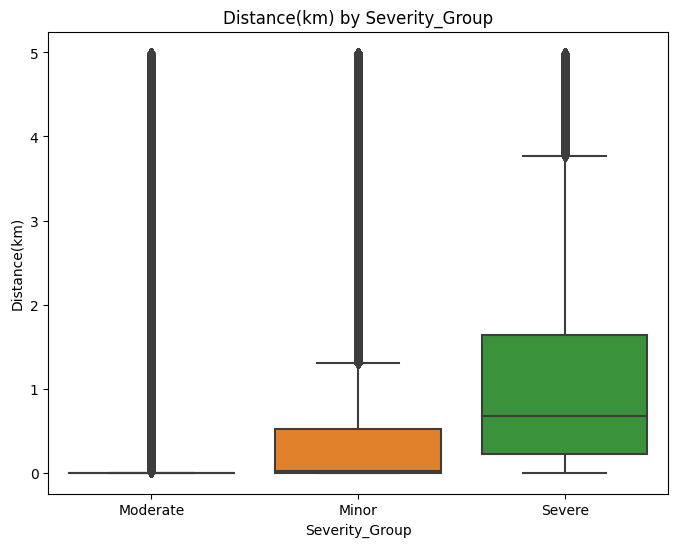

                    count      mean       std  min      25%       50%  \
Severity_Group                                                          
Minor           4654458.0  0.473370  0.901627  0.0  0.00000  0.016093   
Moderate        1203158.0  0.224967  0.695662  0.0  0.00000  0.000000   
Severe           106957.0  1.130084  1.210239  0.0  0.22048  0.679141   

                     75%      max  
Severity_Group                     
Minor           0.519817  4.99861  
Moderate        0.000000  4.99861  
Severe          1.639917  4.99861  


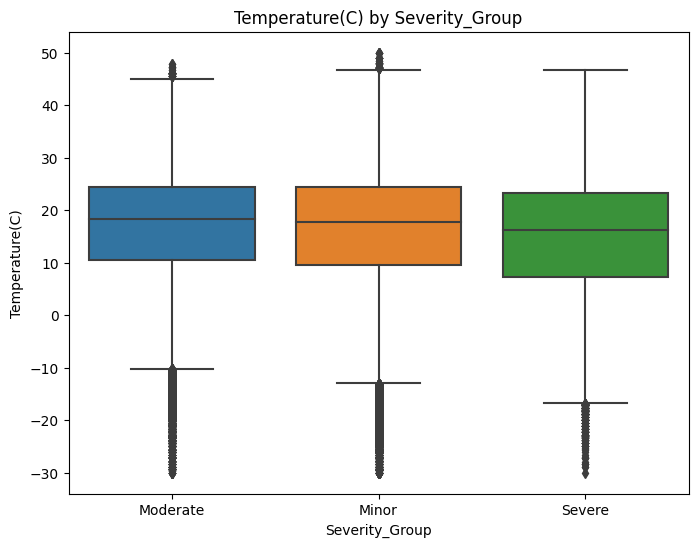

                    count       mean        std   min        25%        50%  \
Severity_Group                                                                
Minor           4654458.0  16.539620  10.513984 -30.0   9.444444  17.777778   
Moderate        1203158.0  16.886871  10.363590 -30.0  10.555556  18.277778   
Severe           106957.0  14.982169  10.755166 -30.0   7.222222  16.111111   

                      75%        max  
Severity_Group                        
Minor           24.444444  50.000000  
Moderate        24.444444  47.777778  
Severe          23.333333  46.666667  


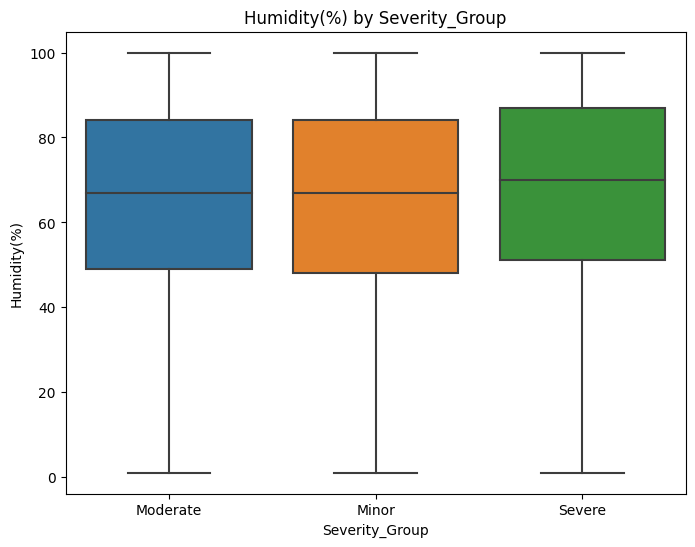

                    count       mean        std  min   25%   50%   75%    max
Severity_Group                                                               
Minor           4648291.0  64.975584  22.861467  1.0  48.0  67.0  84.0  100.0
Moderate        1201943.0  65.263700  22.308612  1.0  49.0  67.0  84.0  100.0
Severe           106794.0  67.211182  22.322280  1.0  51.0  70.0  87.0  100.0


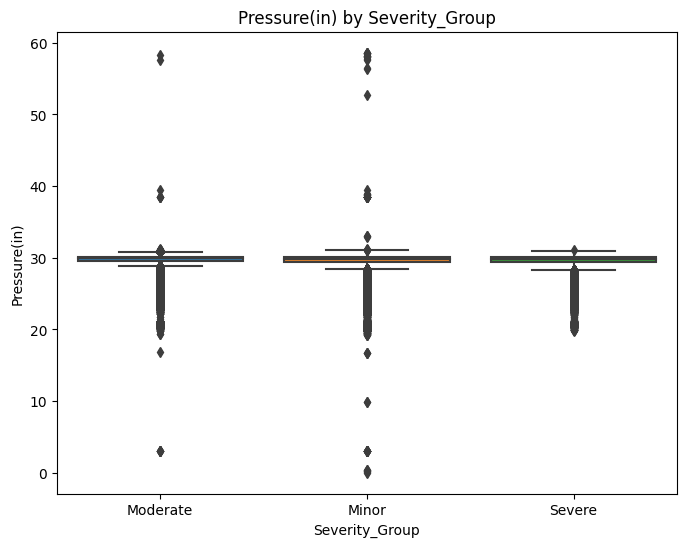

                    count       mean       std    min    25%    50%    75%  \
Severity_Group                                                               
Minor           4649954.0  29.549446  0.959898   0.00  29.37  29.85  30.03   
Moderate        1201605.0  29.696418  0.881184   2.98  29.60  29.93  30.07   
Severe           106799.0  29.522458  1.147481  19.74  29.36  29.86  30.06   

                  max  
Severity_Group         
Minor           58.63  
Moderate        58.32  
Severe          31.12  


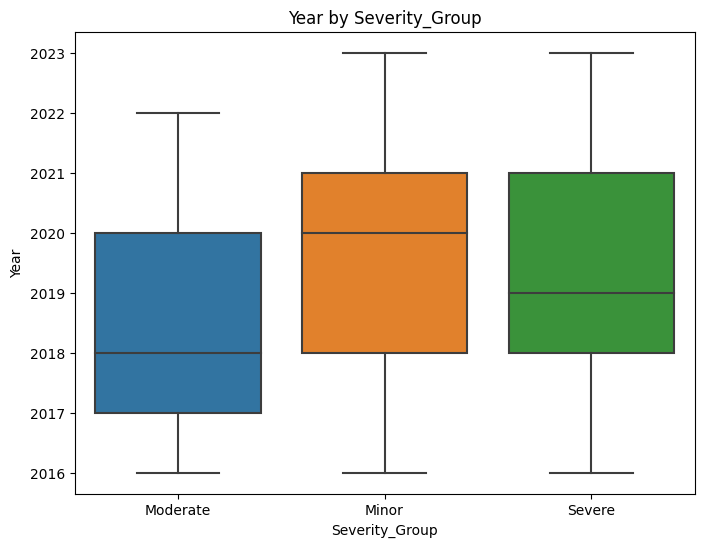

                    count         mean       std     min     25%     50%  \
Severity_Group                                                             
Minor           4654458.0  2019.868380  1.902111  2016.0  2018.0  2020.0   
Moderate        1203158.0  2018.667174  1.691586  2016.0  2017.0  2018.0   
Severe           106957.0  2019.341670  1.962269  2016.0  2018.0  2019.0   

                   75%     max  
Severity_Group                  
Minor           2021.0  2023.0  
Moderate        2020.0  2022.0  
Severe          2021.0  2023.0  


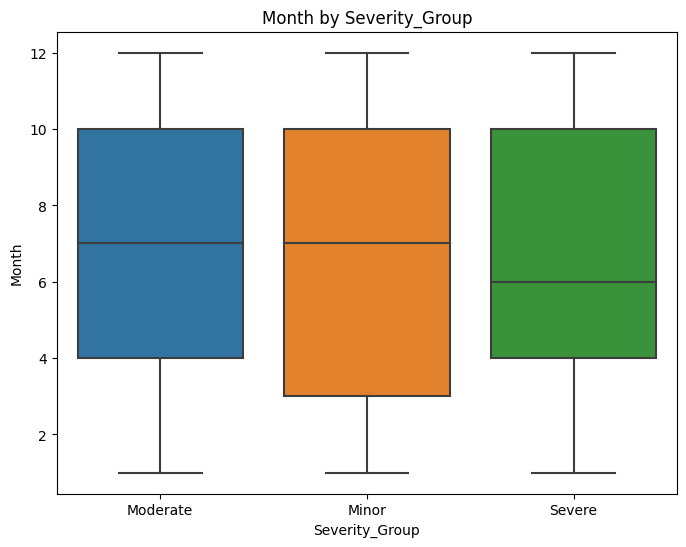

                    count      mean       std  min  25%  50%   75%   max
Severity_Group                                                          
Minor           4654458.0  6.713753  3.624108  1.0  3.0  7.0  10.0  12.0
Moderate        1203158.0  6.597177  3.432930  1.0  4.0  7.0  10.0  12.0
Severe           106957.0  6.513178  3.517557  1.0  4.0  6.0  10.0  12.0


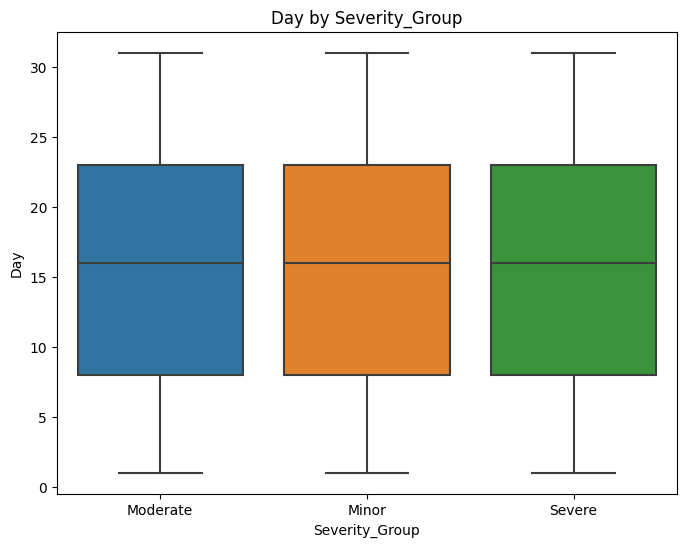

                    count       mean       std  min  25%   50%   75%   max
Severity_Group                                                            
Minor           4654458.0  15.722219  8.684351  1.0  8.0  16.0  23.0  31.0
Moderate        1203158.0  15.743448  8.711740  1.0  8.0  16.0  23.0  31.0
Severe           106957.0  15.803566  8.708365  1.0  8.0  16.0  23.0  31.0


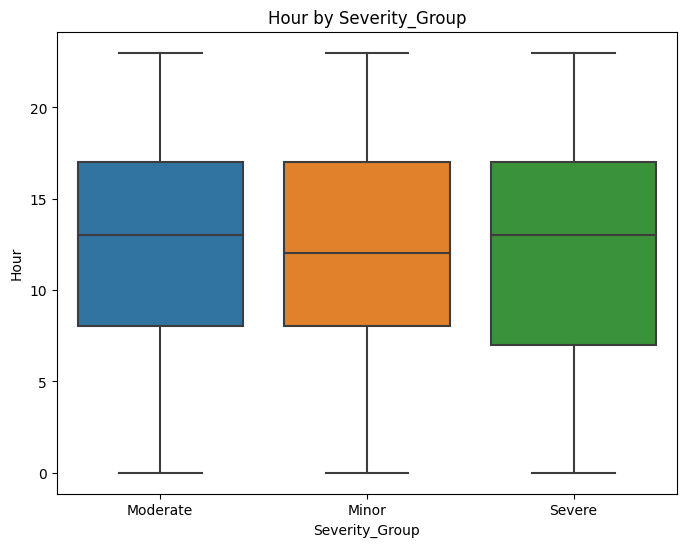

                    count       mean       std  min  25%   50%   75%   max
Severity_Group                                                            
Minor           4654458.0  12.188911  5.433484  0.0  8.0  12.0  17.0  23.0
Moderate        1203158.0  12.496860  5.229242  0.0  8.0  13.0  17.0  23.0
Severe           106957.0  12.216349  6.352828  0.0  7.0  13.0  17.0  23.0


In [42]:
for col in numeric_cols:
    plt.figure(figsize=(8, 6)) # Create a new figure for each plot
    # Use sns.boxplot with data and x, y parameters
    ax = sns.boxplot(x='Severity_Group', y=col, data=df1) 
    ax.set_title(f'{col} by Severity_Group') # Set the title using the axes object
    plt.show() # Display the plot
    print(df1.groupby('Severity_Group')[col].describe())


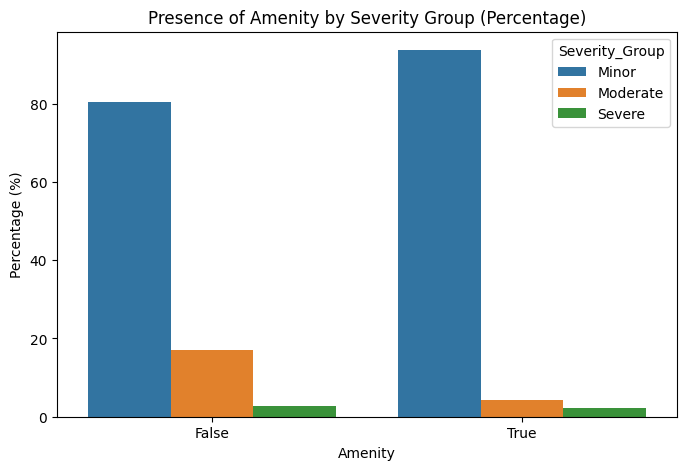


Amenity presence by Severity (percentage):
Severity_Group      Minor   Moderate    Severe
Amenity                                       
False           80.372481  16.971918  2.655600
True            93.706272   4.183362  2.110366
----------------------------------------


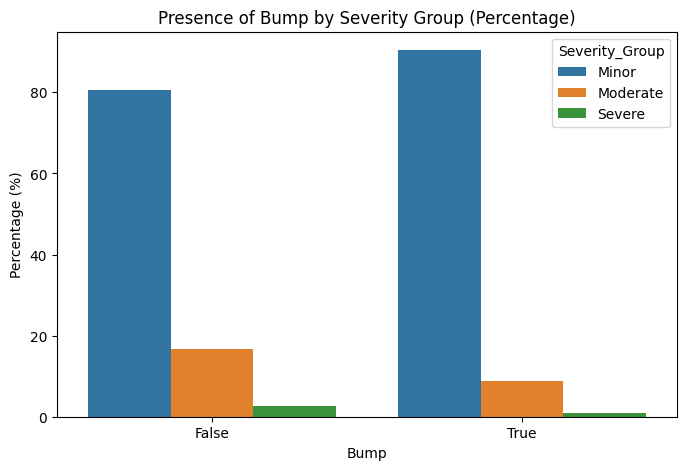


Bump presence by Severity (percentage):
Severity_Group      Minor   Moderate    Severe
Bump                                          
False           80.534183  16.816196  2.649620
True            90.438247   8.708025  0.853728
----------------------------------------


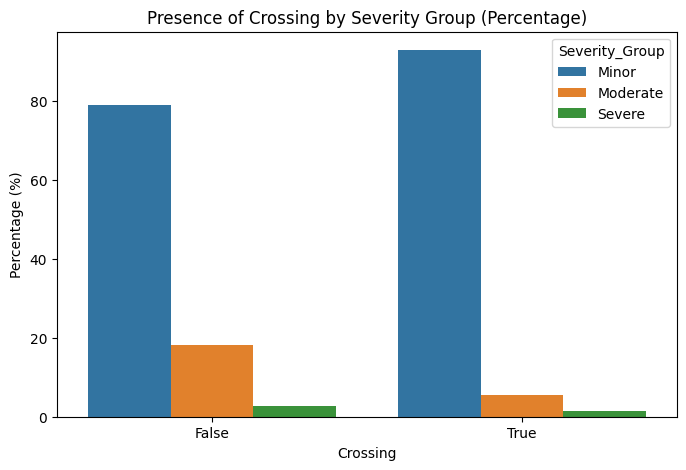


Crossing presence by Severity (percentage):
Severity_Group      Minor   Moderate    Severe
Crossing                                      
False           78.955527  18.254885  2.789589
True            92.958502   5.497143  1.544355
----------------------------------------


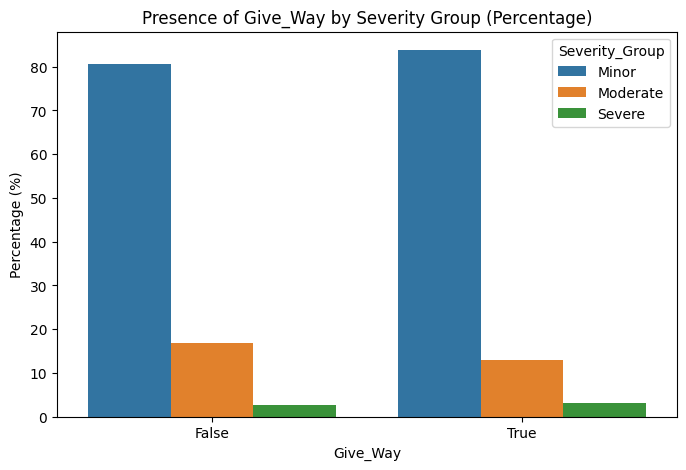


Give_Way presence by Severity (percentage):
Severity_Group      Minor   Moderate    Severe
Give_Way                                      
False           80.522964  16.830859  2.646178
True            83.844514  12.954458  3.201028
----------------------------------------


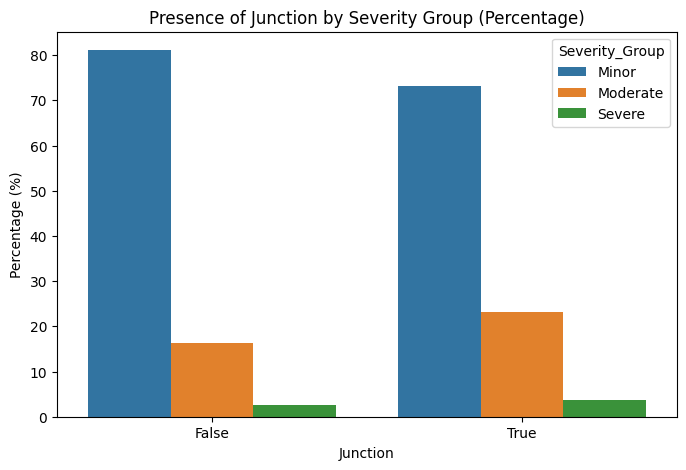


Junction presence by Severity (percentage):
Severity_Group      Minor   Moderate    Severe
Junction                                      
False           81.123918  16.303375  2.572707
True            73.207641  23.190313  3.602046
----------------------------------------


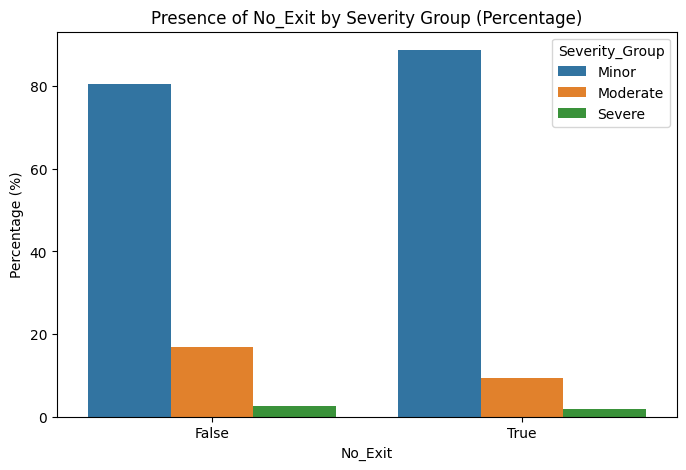


No_Exit presence by Severity (percentage):
Severity_Group      Minor   Moderate    Severe
No_Exit                                       
False           80.517935  16.831332  2.650733
True            88.723459   9.388590  1.887951
----------------------------------------


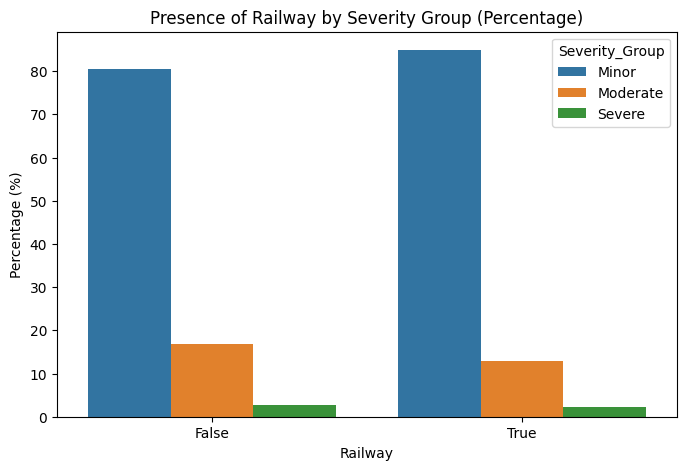


Railway presence by Severity (percentage):
Severity_Group      Minor   Moderate    Severe
Railway                                       
False           80.500821  16.847541  2.651638
True            84.869885  12.805506  2.324609
----------------------------------------


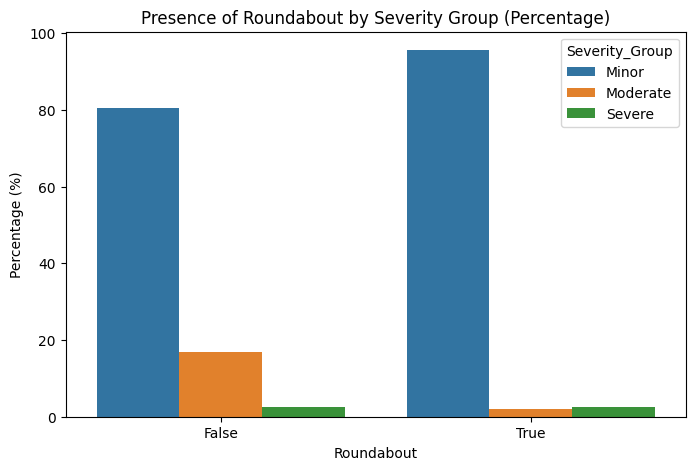


Roundabout presence by Severity (percentage):
Severity_Group      Minor   Moderate    Severe
Roundabout                                    
False           80.538202  16.812987  2.648812
True            95.582329   2.008032  2.409639
----------------------------------------


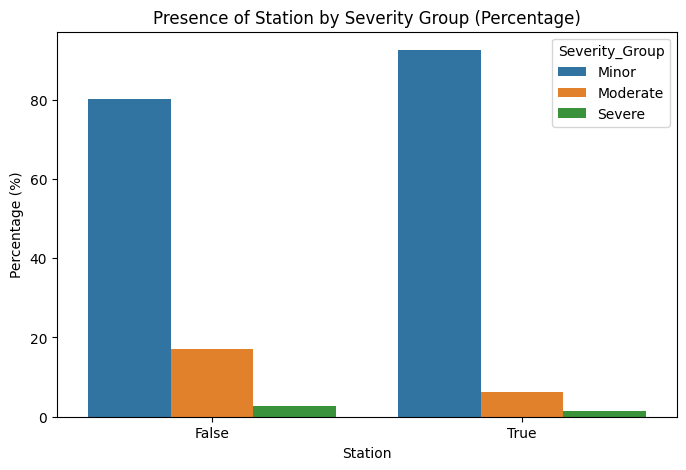


Station presence by Severity (percentage):
Severity_Group      Minor  Moderate    Severe
Station                                      
False           80.217998  17.09892  2.683082
True            92.493351   6.13568  1.370969
----------------------------------------


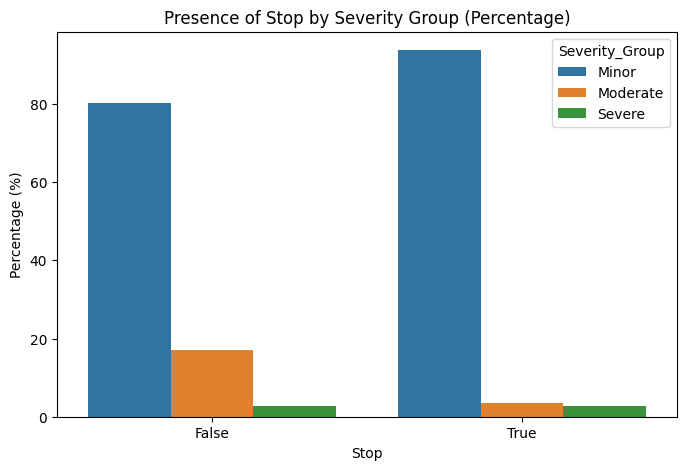


Stop presence by Severity (percentage):
Severity_Group      Minor   Moderate    Severe
Stop                                          
False           80.160974  17.190339  2.648688
True            93.778076   3.569046  2.652877
----------------------------------------


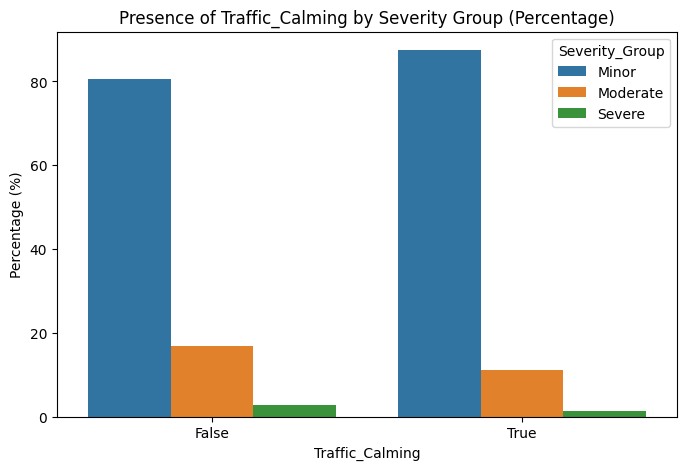


Traffic_Calming presence by Severity (percentage):
Severity_Group       Minor   Moderate    Severe
Traffic_Calming                                
False            80.531852  16.818020  2.650128
True             87.483548  11.213477  1.302974
----------------------------------------


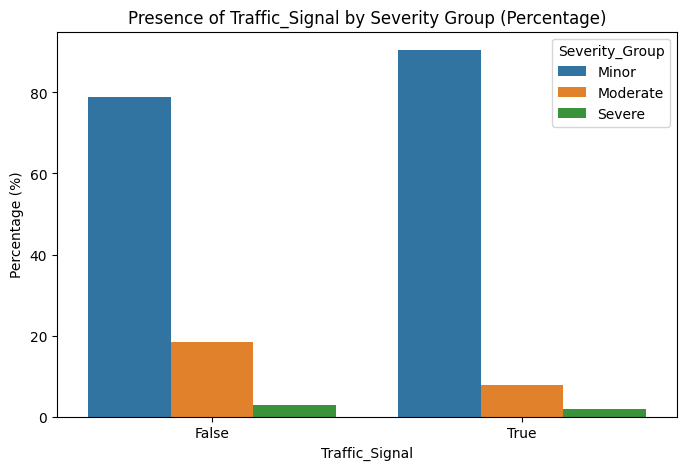


Traffic_Signal presence by Severity (percentage):
Severity_Group      Minor   Moderate    Severe
Traffic_Signal                                
False           78.809900  18.387206  2.802894
True            90.491199   7.747086  1.761715
----------------------------------------


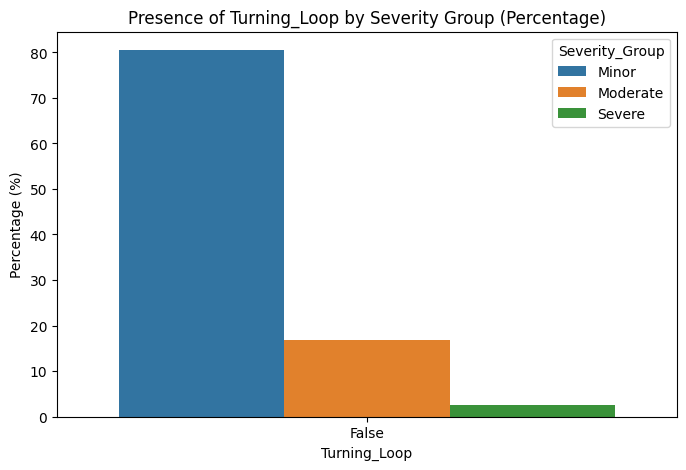


Turning_Loop presence by Severity (percentage):
Severity_Group      Minor  Moderate    Severe
Turning_Loop                                 
False           80.538686  16.81251  2.648804
----------------------------------------


In [43]:
for col in bool_cols:
    # Compute percentages within each boolean category
    plot_df = (
        df
        .groupby([col, 'Severity_Group'])
        .size()
        .reset_index(name='count')
    )

    plot_df['percent'] = (
        plot_df['count']
        / plot_df.groupby(col)['count'].transform('sum')
        * 100
    )

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        data=plot_df,
        x=col,
        y='percent',
        hue='Severity_Group'
    )

    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'Presence of {col} by Severity Group (Percentage)')
    plt.show()

    print(f"\n{col} presence by Severity (percentage):")
    print(pd.crosstab(df[col], df['Severity_Group'], normalize='index') * 100)
    print("-" * 40)


Exploratory Observations from Plotted Distributions


Distance Affected


Severe accidents exhibit substantially greater variability in distance affected compared to moderate and minor accidents.


The moderate category shows a very narrow spread (approximately 0.9), indicating relatively consistent impact distances.


Both minor and severe accidents display positive skewness, suggesting that as severity increases, the likelihood of larger affected distances also increases.


Notably, minor accidents span a wider distance range than moderate accidents, and in some cases exceed them, indicating that distance affected does not increase monotonically with severity.




Temperature


The temperature distributions are broadly similar across severity levels.


Minor and moderate accidents occur more frequently at higher temperature extremes, potentially reflecting reduced traffic volumes or altered driving behavior during extreme heat.


Severe accidents show slightly broader temperature coverage, indicating occurrence across a wider range of thermal conditions.




Humidity


All severity categories exhibit similar humidity distributions.


Each shows a longer lower whisker, implying a greater spread toward lower humidity values.


This suggests that humidity, while variable, does not strongly differentiate accident severity in this dataset.




Temporal Trends by Year


Moderate accidents are notably absent in 2023, which warrants further investigation. Possible explanations include data collection issues, reporting changes, or classification differences.


Severe accidents increase significantly after 2019, particularly in the post-COVID period.


Minor accidents decline sharply after 2020, which may reflect changes in travel behavior, traffic volume, enforcement, or reporting practices following the pandemic.




Monthly Distribution


Minor accidents are relatively evenly distributed from March through October, with a slight skew toward the summer months.


This pattern may reflect seasonal road accessibility, weather conditions, or increased travel during warmer months.


Further analysis at monthly and hourly granularity could help validate these hypotheses.




Day of Month and Hourly Patterns


Accidents across all severity levels are fairly evenly distributed across the middle days of the month, with no strong edge effects.


Hourly distributions show that most accidents occur between 08:00 and 17:00.


Minor accidents are more common during afternoon hours, while severe accidents show a slight concentration in morning hours, likely associated with peak traffic congestion and commuting patterns.







In [44]:
# Check data availability
print(df1['Year'].value_counts().sort_index()/len(df1)*100)
print("\nSeverity_Group by Year:")
print(pd.crosstab(df['Year'], df['Severity_Group']))

Year
2016     6.280651
2017    11.127737
2018    13.952482
2019    14.463818
2020    14.940533
2021    18.363628
2022    18.439409
2023     2.431742
Name: count, dtype: float64

Severity_Group by Year:
Severity_Group    Minor  Moderate  Severe
Year                                     
2016             270251    126215   14355
2017             462756    231169   24168
2018             574927    292706   25793
2019             688347    237853   28103
2020             962494    185352   31067
2021            1384779    148085   30889
2022            1641221     77957   43274
2023             239572         0    7061


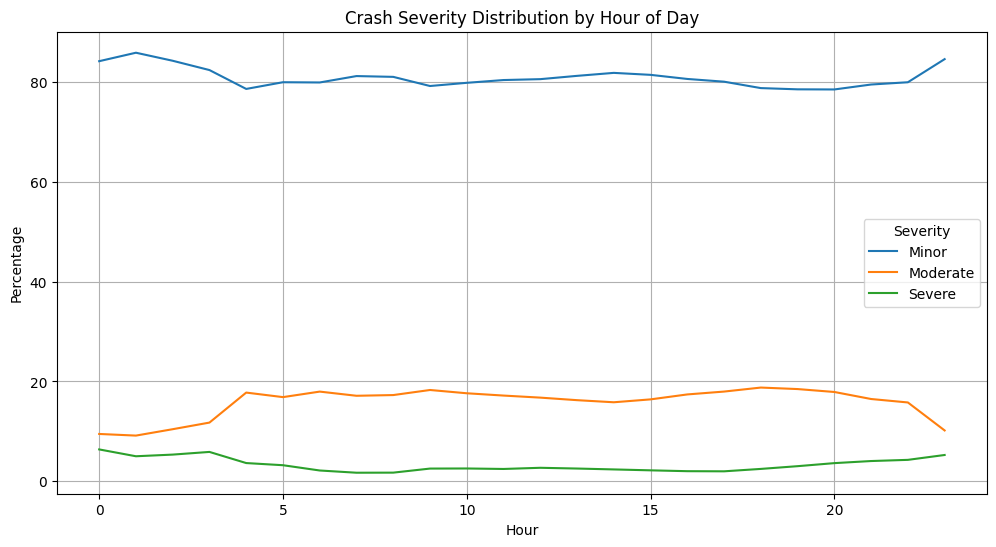

In [45]:
# Create a more detailed hour analysis
hour_severity = pd.crosstab(df['Hour'], df['Severity_Group'], normalize='index') * 100

# Plot it
import matplotlib.pyplot as plt
hour_severity.plot(kind='line', figsize=(12,6))
plt.title('Crash Severity Distribution by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Percentage')
plt.legend(title='Severity')
plt.grid(True)
plt.show()

In [46]:
# Top 15 weather conditions
top_weather = df['Weather_Condition'].value_counts().head(15).index

# Filter to top weather conditions
df_top_weather = df[df['Weather_Condition'].isin(top_weather)]

# Severity by weather
weather_severity = pd.crosstab(df_top_weather['Weather_Condition'], 
                                df_top_weather['Severity_Group'], 
                                normalize='index') * 100

weather_severity.sort_values('Severe', ascending=False)/len(df1)*100

Severity_Group        Minor  Moderate    Severe
Weather_Condition                              
Light Snow         0.001326  0.000288  0.000062
Overcast           0.001091  0.000525  0.000061
Light Drizzle      0.001270  0.000351  0.000055
Clear              0.001114  0.000508  0.000055
Scattered Clouds   0.001087  0.000541  0.000049
Fair / Windy       0.001467  0.000162  0.000048
Fog                0.001468  0.000162  0.000047
Cloudy             0.001438  0.000192  0.000047
Light Rain         0.001294  0.000338  0.000044
Rain               0.001274  0.000362  0.000040
Fair               0.001480  0.000157  0.000039
Heavy Rain         0.001262  0.000375  0.000039
Mostly Cloudy      0.001326  0.000312  0.000039
Partly Cloudy      0.001333  0.000306  0.000038
Haze               0.001338  0.000315  0.000024

In [47]:
# Top 10 states
print("Top 10 States - Severity Distribution:")
top_states = df['State'].value_counts().head(10).index
state_severity = pd.crosstab(df[df['State'].isin(top_states)]['State'], 
                              df[df['State'].isin(top_states)]['Severity_Group'], 
                              normalize='index') * 100
print(state_severity.sort_values('Severe', ascending=False))

# Source
print("\n\nSource - Severity Distribution:")
print(pd.crosstab(df['Source'], df['Severity_Group'], normalize='index') * 100)

Top 10 States - Severity Distribution:
Severity_Group      Minor   Moderate    Severe
State                                         
VA              77.076897  16.921804  6.001299
PA              84.189198  10.461533  5.349268
OR              91.303573   5.415785  3.280641
NY              76.775779  20.135073  3.089148
NC              88.174418   8.749287  3.076295
FL              86.683133  11.822989  1.493879
TX              78.098165  20.664954  1.236881
SC              88.089357  11.101614  0.809030
CA              83.616022  15.608640  0.775338
MN              83.992941  15.557777  0.449283


Source - Severity Distribution:
Severity_Group      Minor   Moderate    Severe
Source                                        
Source1         91.866784   3.734206  4.399010
Source2         66.075387  33.492801  0.431812
Source3         68.272598  31.571327  0.156075


In [48]:
# Check each twilight variable
twilight_vars = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

for var in twilight_vars:
    print(f"\n{var}:")
    print(df[var].value_counts())
    print(f"\nSeverity by {var}:")
    print(pd.crosstab(df[var], df['Severity_Group'], normalize='index') * 100)
    print("-" * 50)


Sunrise_Sunset:
Sunrise_Sunset
Day      5334553
Night    2370595
Name: count, dtype: int64

Severity by Sunrise_Sunset:
Severity_Group      Minor   Moderate    Severe
Sunrise_Sunset                                
Day             80.269050  17.492900  2.238051
Night           81.079602  15.417226  3.503171
--------------------------------------------------

Civil_Twilight:
Civil_Twilight
Day      5695619
Night    2009529
Name: count, dtype: int64

Severity by Civil_Twilight:
Severity_Group      Minor   Moderate    Severe
Civil_Twilight                                
Day             80.262567  17.498748  2.238686
Night           81.243615  15.027701  3.728685
--------------------------------------------------

Nautical_Twilight:
Nautical_Twilight
Day      6076156
Night    1628992
Name: count, dtype: int64

Severity by Nautical_Twilight:
Severity_Group         Minor   Moderate    Severe
Nautical_Twilight                                
Day                80.257814  17.492606  2.249580


DROPPED:

Source (data provider, not predictive)
Sunrise_Sunset, Civil_Twilight, Nautical_Twilight (redundant with Astronomical_Twilight)
Severity (original column, replaced by Severity_Group)

In [50]:
df1 = df1.drop(['Source',"Severity",'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight'], axis=1)

In [51]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5964573 entries, 0 to 7728393
Data columns (total 26 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Start_Time             datetime64[ns]
 1   Distance(km)           float64       
 2   State                  object        
 3   Temperature(C)         float64       
 4   Humidity(%)            float64       
 5   Pressure(in)           float64       
 6   Weather_Condition      object        
 7   Amenity                bool          
 8   Bump                   bool          
 9   Crossing               bool          
 10  Give_Way               bool          
 11  Junction               bool          
 12  No_Exit                bool          
 13  Railway                bool          
 14  Roundabout             bool          
 15  Station                bool          
 16  Stop                   bool          
 17  Traffic_Calming        bool          
 18  Traffic_Signal         bool

# EDA PHASE

In [ ]:
# For each state, calculate % of crashes with safety features
safety_features = ['Traffic_Signal', 'Crossing', 'Bump', 'Roundabout']
danger_features = ['Junction', 'Give_Way']

state_safety = df.groupby('State')[safety_features].mean() * 100
state_danger = df.groupby('State')[danger_features].mean() * 100

# Calculate overall safety score
state_safety['Safety_Score'] = state_safety.mean(axis=1) - state_danger.mean(axis=1)

# Get severe crash rate by state
state_severity = df.groupby('State')['Severity_Group'].apply(
    lambda x: (x == 'Severe').sum() / len(x) * 100
)

# Combine
state_analysis = pd.DataFrame({
    'Safety_Score': state_safety['Safety_Score'],
    'Severe_Pct': state_severity
}).sort_values('Severe_Pct', ascending=False)

print(state_analysis.head(15))

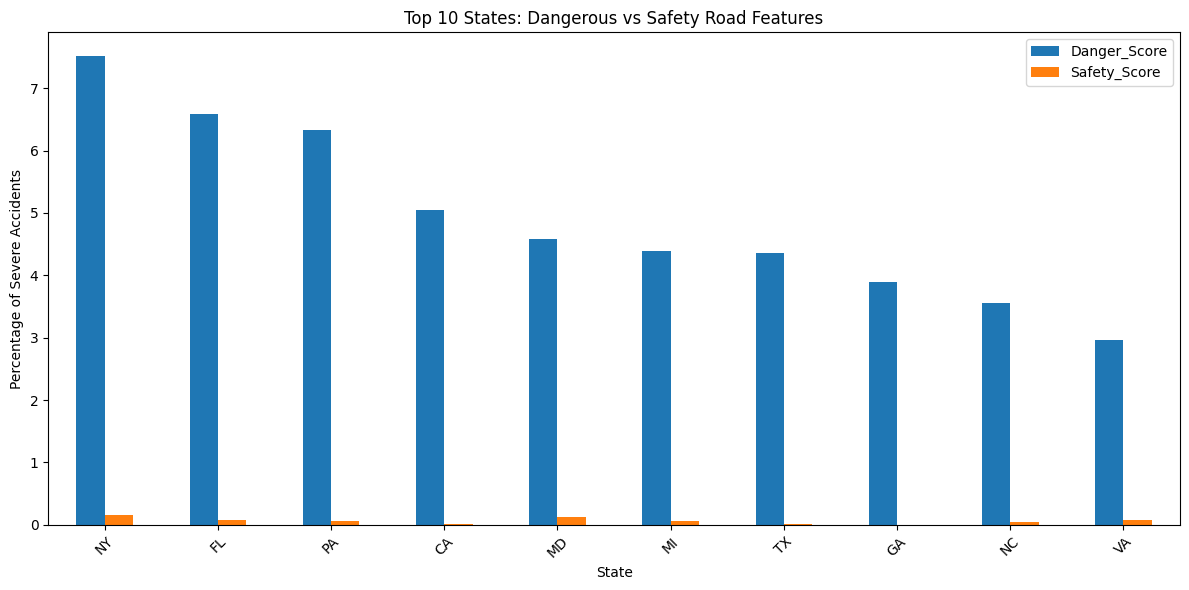

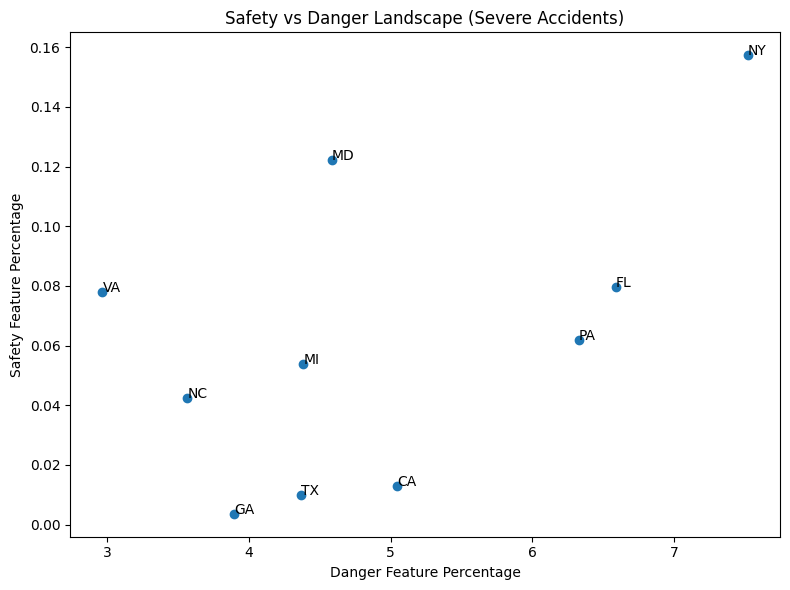

Junction  Give_Way  Crossing  Stop  Traffic_Signal  Railway  \
State                                                                
NY        12.11      1.53     15.84  4.49           17.35     1.33   
FL        13.79      0.20     14.81  0.76           16.08     0.48   
PA        13.45      2.16      7.30  6.68           13.69     1.03   
CA        16.84      0.10      5.19  3.41            8.84     0.94   
MD        10.10      0.33      5.81  1.71           13.99     0.16   
MI        15.47      0.15      5.33  0.84            8.57     0.32   
TX        20.23      0.63      2.31  0.33            6.68     0.35   
GA        12.08      0.83      4.30  2.26            6.85     0.95   
NC        11.00      0.51      4.06  1.51            7.23     0.63   
VA         4.92      0.53      4.55  2.16            8.07     0.52   

       Turning_Loop  Traffic_Calming  Roundabout  Bump  No_Exit  Danger_Score  \
State                                                                           
NY              0.0             0.15         0.0  0.10     0.37          7.52   
FL              0.0             0.04         0.0  0.00     0.28          6.59   
PA              0.0             0.04         0.0  0.02     0.19          6.33   
CA              0.0             0.01         0.0  0.01     0.03          5.04   
MD              0.0             0.35         0.0  0.02     0.12          4.58   
MI              0.0             0.02         0.0  0.02     0.17          4.38   
TX              0.0             0.02         0.0  0.00     0.02          4.36   
GA              0.0             0.01         0.0  0.00     0.00          3.90   
NC              0.0             0.00         0.0  0.00     0.17          3.56   
VA              0.0             0.01         0.0  0.00     0.30          2.96   

       Safety_Score  
State                
NY             0.16  
FL             0.08  
PA             0.06  
CA             0.01  
MD             0.12  
MI             0.05  
TX             0.01  
GA             0.00  
NC             0.04  
VA             0.08

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1. Define feature groups
# -----------------------------
danger_features = [
    'Junction', 'Give_Way', 'Crossing',
    'Stop', 'Traffic_Signal', 'Railway', 'Turning_Loop'
]

safety_features = [
    'Traffic_Calming', 'Roundabout', 'Bump', 'No_Exit'
]

# -----------------------------
# 2. Filter by Severity Group
# -----------------------------
# Change 'High' if your severe label is different
df_severe = df1[df1['Severity_Group'] == 'Severe']

# -----------------------------
# 3. Select top 10 states
# -----------------------------
top_states = (
    df_severe['State']
    .value_counts()
    .head(10)
    .index
)

df_top = df_severe[df_severe['State'].isin(top_states)]

# -----------------------------
# 4. Percentage of features per state
# -----------------------------
state_features_pct = (
    df_top
    .groupby('State')[danger_features + safety_features]
    .mean() * 100
)

# -----------------------------
# 5. Create Safety & Danger scores
# -----------------------------
state_features_pct['Danger_Score'] = state_features_pct[danger_features].mean(axis=1)
state_features_pct['Safety_Score'] = state_features_pct[safety_features].mean(axis=1)

# -----------------------------
# 6. Bar Chart: Safety vs Danger
# -----------------------------
state_features_pct[['Danger_Score', 'Safety_Score']] \
    .sort_values('Danger_Score', ascending=False) \
    .plot(kind='bar', figsize=(12,6))

plt.ylabel('Percentage of Severe Accidents')
plt.title('Top 10 States: Dangerous vs Safety Road Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# 7. Scatter Plot: State Risk Map
# -----------------------------
plt.figure(figsize=(8,6))
plt.scatter(
    state_features_pct['Danger_Score'],
    state_features_pct['Safety_Score']
)

for state in state_features_pct.index:
    plt.text(
        state_features_pct.loc[state, 'Danger_Score'],
        state_features_pct.loc[state, 'Safety_Score'],
        state
    )

plt.xlabel('Danger Feature Percentage')
plt.ylabel('Safety Feature Percentage')
plt.title('Safety vs Danger Landscape (Severe Accidents)')
plt.tight_layout()
plt.show()

# -----------------------------
# 8. Final table (for inspection)
# -----------------------------
state_features_pct \
    .round(2) \
    .sort_values('Danger_Score', ascending=False)


/tmp/ipykernel_47/216982020.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['State', 'Severity_Group'])[danger_features]


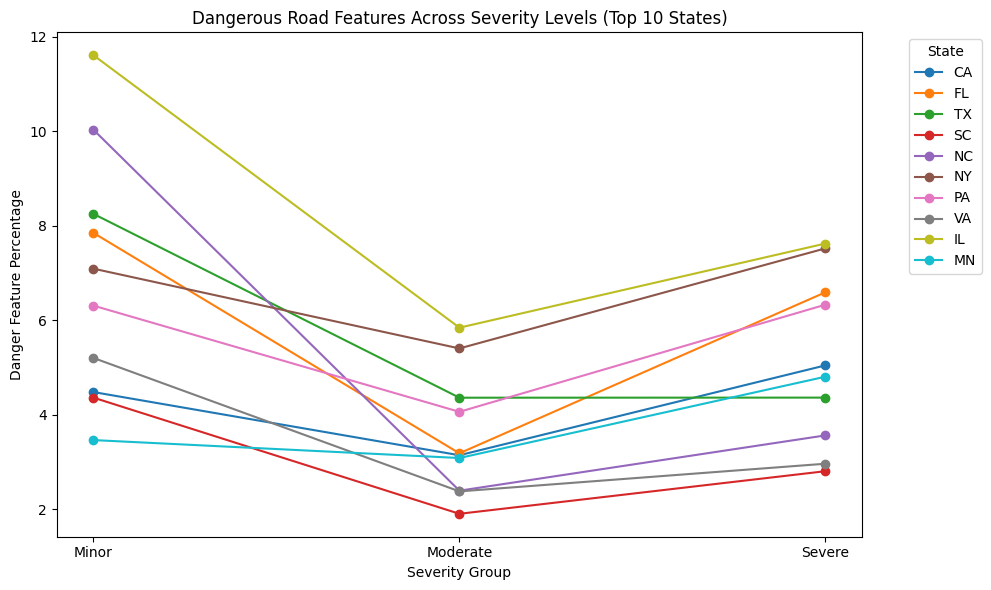

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1. Feature groups
# -----------------------------
danger_features = [
    'Junction', 'Give_Way', 'Crossing',
    'Stop', 'Traffic_Signal', 'Railway', 'Turning_Loop'
]

# -----------------------------
# 2. Severity order (IMPORTANT)
# -----------------------------
severity_order = ['Minor', 'Moderate', 'Severe']
df1['Severity_Group'] = pd.Categorical(
    df1['Severity_Group'],
    categories=severity_order,
    ordered=True
)

# -----------------------------
# 3. Top 10 states (overall)
# -----------------------------
top_states = (
    df1['State']
    .value_counts()
    .head(10)
    .index
)

df_top = df1[df1['State'].isin(top_states)]

# -----------------------------
# 4. Compute % dangerous features
# -----------------------------
severity_state_pct = (
    df_top
    .groupby(['State', 'Severity_Group'])[danger_features]
    .mean()
    .mean(axis=1) * 100
).reset_index(name='Danger_Feature_%')

# -----------------------------
# 5. Line chart
# -----------------------------
plt.figure(figsize=(10,6))

for state in top_states:
    state_data = severity_state_pct[severity_state_pct['State'] == state]
    plt.plot(
        state_data['Severity_Group'],
        state_data['Danger_Feature_%'],
        marker='o',
        label=state
    )

plt.xlabel('Severity Group')
plt.ylabel('Danger Feature Percentage')
plt.title('Dangerous Road Features Across Severity Levels (Top 10 States)')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
